<a href="https://colab.research.google.com/github/himchopra/python_strokeclassification/blob/main/Stroke_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import imblearn
from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import GridSearchCV


from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
#from sklearn.metrics import accuracy_score
#from sklearn.metrics import precision_recall_curve

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier



In [ ]:
df_strokedata = pd.read_csv('stroke_data.csv')
df_strokedata.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
#Checking Data Types
df_strokedata.info()
#Observation : BMI has null values, 201 null values. Total 11 columns (id is considered as reduntant). Out of 11 columns, stroke is dependent (predictor) colun and remaining 10 as explanatory (independent) variables. Out of these 10 variables 5 looks as categorical and 5 as integer 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
# Checking nature of each column
df_strokedata.describe(include='all')

#####
#Observation :
#1. Following data looks continous - age, avg_glucose_level, bmi
#2. Following data looks binary - hypertension, heart_disease, stroke
#3. Following columns are categorical - Gender, ever_married, work_type, Residence_type, smoking_status
######

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5110.000000,5110,5110.000000,5110.000000,5110.000000,5110,5110,5110,5110.000000,4909.000000,5110,5110.000000
unique,NaN,3,NaN,NaN,NaN,2,5,2,NaN,NaN,4,NaN
top,NaN,Female,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,never smoked,NaN
freq,NaN,2994,NaN,NaN,NaN,3353,2925,2596,NaN,NaN,1892,NaN
mean,36517.829354,NaN,43.226614,0.097456,0.054012,NaN,NaN,NaN,106.147677,28.893237,NaN,0.048728
std,21161.721625,NaN,22.612647,0.296607,0.226063,NaN,NaN,NaN,45.283560,7.854067,NaN,0.215320
min,67.000000,NaN,0.080000,0.000000,0.000000,NaN,NaN,NaN,55.120000,10.300000,NaN,0.000000
25%,17741.250000,NaN,25.000000,0.000000,0.000000,NaN,NaN,NaN,77.245000,23.500000,NaN,0.000000
50%,36932.000000,NaN,45.000000,0.000000,0.000000,NaN,NaN,NaN,91.885000,28.100000,NaN,0.000000
75%,54682.000000,NaN,61.000000,0.000000,0.000000,NaN,NaN,NaN,114.090000,33.100000,NaN,0.000000


In [ ]:
#Starting with categorical variables
columns = ['gender','ever_married','Residence_type','work_type','smoking_status']

for col in columns:
  print(df_strokedata.groupby(by=col)['id'].count())
  print('------')

gender
Female    2994
Male      2115
Other        1
Name: id, dtype: int64
------
ever_married
No     1757
Yes    3353
Name: id, dtype: int64
------
Residence_type
Rural    2514
Urban    2596
Name: id, dtype: int64
------
work_type
Govt_job          657
Never_worked       22
Private          2925
Self-employed     819
children          687
Name: id, dtype: int64
------
smoking_status
Unknown            1544
formerly smoked     885
never smoked       1892
smokes              789
Name: id, dtype: int64
------


In [ ]:
# Columns with binary values

columns = ['hypertension', 'ever_married', 'heart_disease', 'stroke']

for col in columns:
  print(df_strokedata.groupby(by=col)['id'].count())
  print('------')

# Observation : Disease prevalence rate (Stroke) is 4.87%

hypertension
0    4612
1     498
Name: id, dtype: int64
------
ever_married
No     1757
Yes    3353
Name: id, dtype: int64
------
heart_disease
0    4834
1     276
Name: id, dtype: int64
------
stroke
0    4861
1     249
Name: id, dtype: int64
------


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

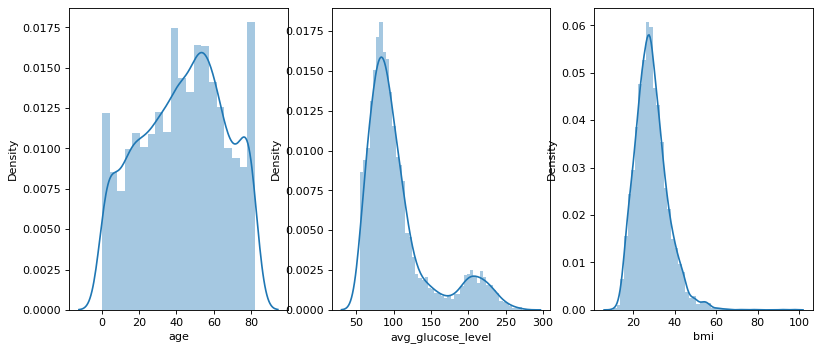

In [ ]:
# Distribution graph of continous variables

fig, axes = plt.subplots(1, 3, figsize=(12,5), dpi= 80)
sns.distplot(df_strokedata.age,ax=axes[0])
sns.distplot(df_strokedata.avg_glucose_level,ax=axes[1])
sns.distplot(df_strokedata.bmi,ax=axes[2])

In [ ]:
def univariate_column(i_col):
  fig, axes = plt.subplots(1, 2, figsize=(12,3), dpi= 80)

  df_groupby = df_strokedata.groupby([i_col, 'stroke'])['id'].count()
  # Get the count of records by gender
  df_total = df_strokedata.groupby([i_col])['id'].count()
  # Get the percentage for 100% stacked bar chart
  df_pct = df_groupby / df_total * 100
  # Create proper DataFrame's format
  df_pct = df_pct.unstack()
  sns.countplot(df_strokedata[i_col], hue = df_strokedata['stroke'],ax=axes[0])
  sns.scatterplot(data=df_pct.iloc[:,1],ax=axes[1])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seab

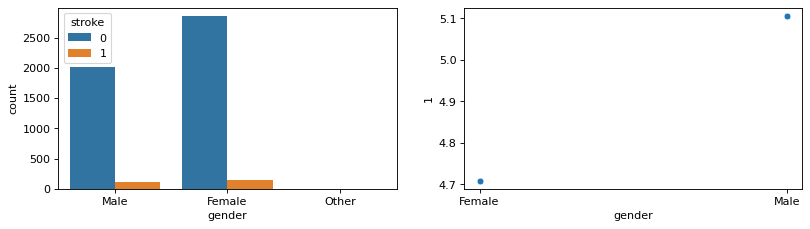

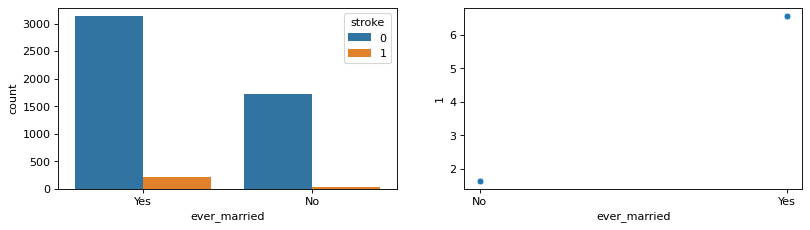

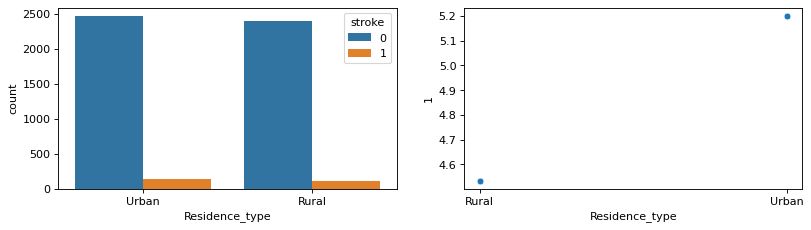

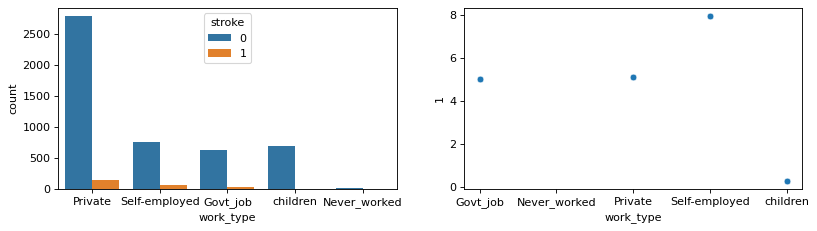

In [ ]:
# Univariate analysis to identify stoke data is dependent on which all variables

# Starting with categorical variables

columns = ['gender','ever_married','Residence_type','work_type']

for col in columns:
  univariate_column(col)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seab

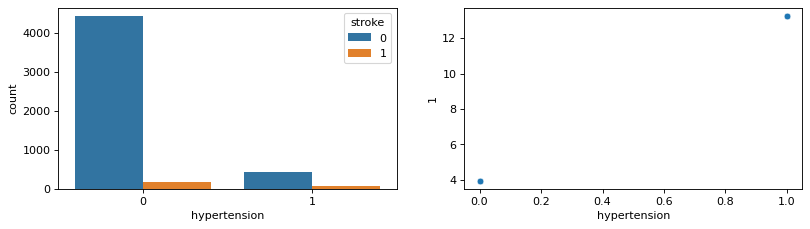

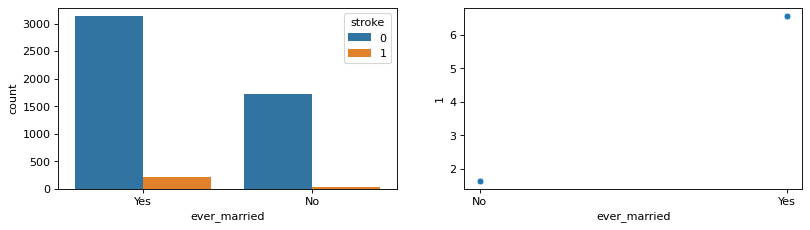

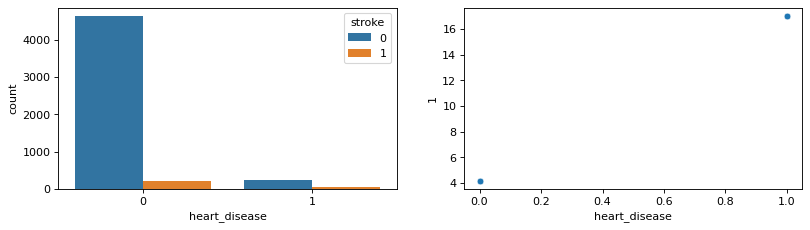

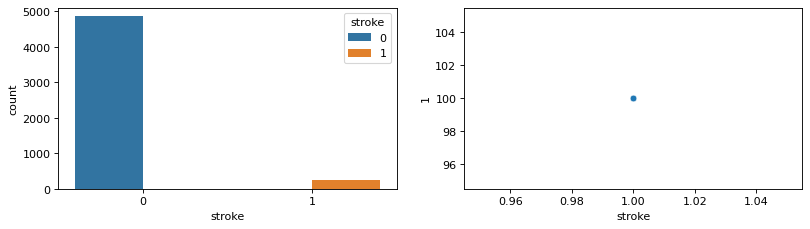

In [ ]:
columns = ['hypertension', 'ever_married', 'heart_disease', 'stroke']

for col in columns:
  univariate_column(col)

In [ ]:
def univariate_continous(i_col):
  fig, axes = plt.subplots(1, 2, figsize=(12,3), dpi= 80)

  df_groupby = df_strokedata.groupby([i_col, 'stroke'])['id'].count()
  # Get the count of records by gender
  df_total = df_strokedata.groupby([i_col])['id'].count()
  # Get the percentage for 100% stacked bar chart
  df_pct = df_groupby / df_total * 100
  # Create proper DataFrame's format
  df_pct = df_pct.unstack()
  sns.boxplot(data=df_strokedata,x='stroke',y=i_col,ax=axes[0])
  sns.scatterplot(data=df_pct.iloc[:,1],ax=axes[1])

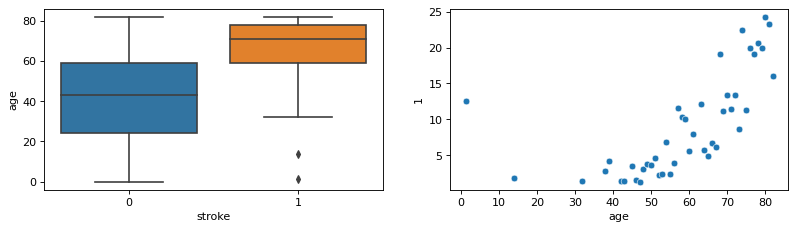

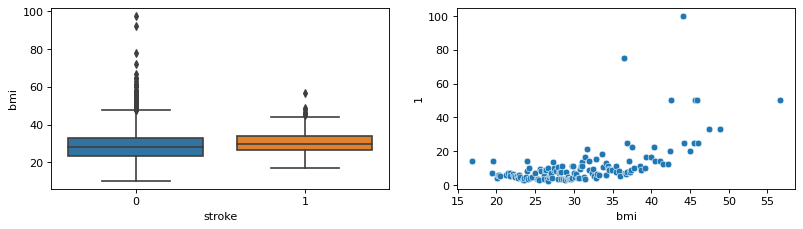

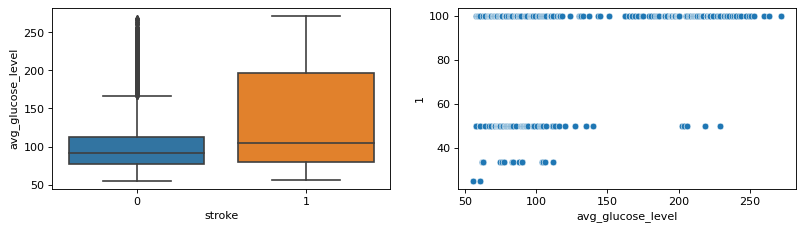

In [ ]:
columns = ['age', 'bmi', 'avg_glucose_level']#, 'stroke']

for col in columns:
  univariate_continous(col)

In [ ]:
# Creating another copy of input data to preserve original data
df = df_strokedata.copy()
df_strokedata = df_strokedata[df_strokedata.gender != 'Other']

In [ ]:
## Encoding Variables

## Where there are only 2 unique values we change values with a flag else we create encoding using dummy
columns = ['gender','ever_married','work_type','Residence_type','smoking_status']

for col in columns:
  print(col)
  print(df_strokedata[col].nunique())

df_strokedata["Residence_type"] = df_strokedata["Residence_type"].apply(lambda x: 1 if x=="Urban" else 0)
df_strokedata["ever_married"] = df_strokedata["ever_married"].apply(lambda x: 1 if x=="Yes" else 0)
df_strokedata["gender"] = df_strokedata["gender"].apply(lambda x: 1 if x=="Male" else 0)


df_strokedata = pd.get_dummies(data=df_strokedata, columns=['smoking_status'])
df_strokedata = pd.get_dummies(data=df_strokedata, columns=['work_type'])
#df_strokedata = pd.get_dummies(data=df_strokedata, columns=['gender'])

gender
2
ever_married
2
work_type
5
Residence_type
2
smoking_status
4


<ipython-input-14-3aea3863cdea>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strokedata["Residence_type"] = df_strokedata["Residence_type"].apply(lambda x: 1 if x=="Urban" else 0)
<ipython-input-14-3aea3863cdea>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strokedata["ever_married"] = df_strokedata["ever_married"].apply(lambda x: 1 if x=="Yes" else 0)
<ipython-input-14-3aea3863cdea>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [ ]:
# Treating null in BMI data
# Since BMI data is pretty much normally distributed, null values of BMI are replaced with avg

mean_value = df_strokedata['bmi'].mean()
df_strokedata.fillna(mean_value, inplace = True)

In [ ]:
df_strokedata.drop(columns=['smoking_status_Unknown','work_type_children'],inplace=True)

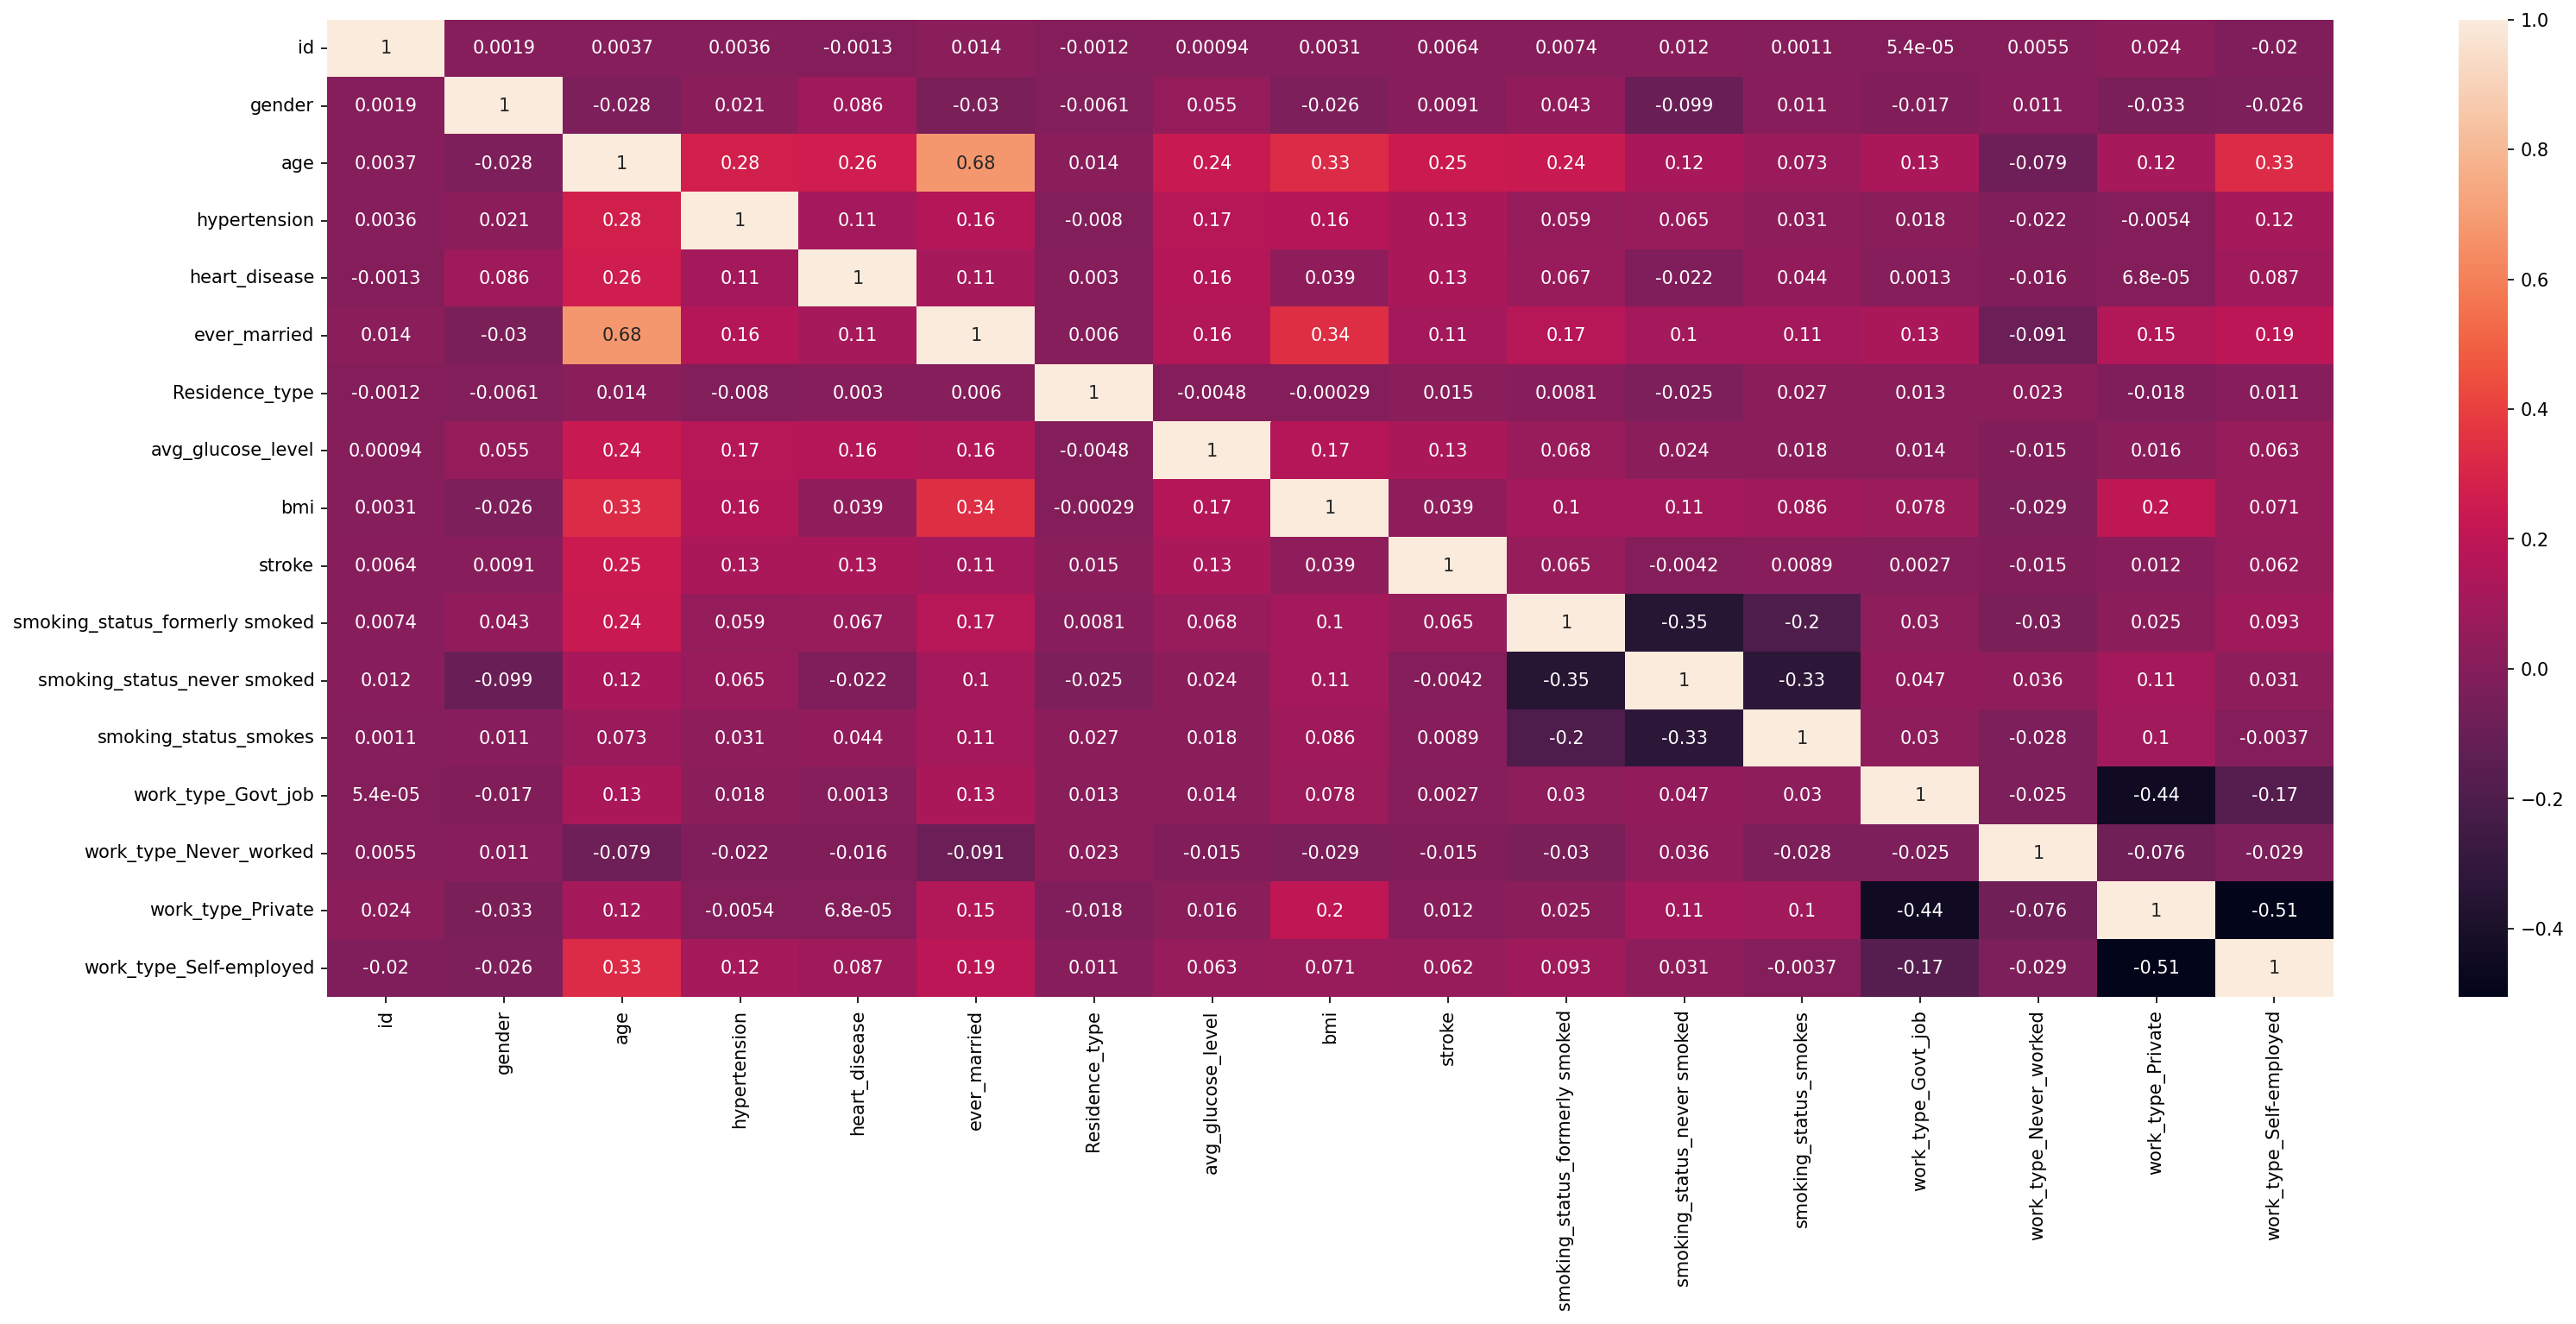

In [ ]:
# plotting the heat map of correlation matrix using seaborn library
plt.figure(figsize=(25,10),dpi=150)
sns.heatmap(df_strokedata.corr(),annot=True, xticklabels= df_strokedata.corr().columns, yticklabels= df_strokedata.corr().columns)

In [ ]:
# Feature Engineering


Feature 0 : gender: 323.559817
Feature 1 : age: 4380.142903
Feature 2 : hypertension: 24.434162
Feature 3 : heart_disease: 6.654377
Feature 4 : ever_married: 264.174771
Feature 5 : Residence_type: 220.982331
Feature 6 : avg_glucose_level: 756.223935
Feature 7 : bmi: 75.764827
Feature 8 : smoking_status_formerly smoked: 96.018472
Feature 9 : smoking_status_never smoked: 457.017210
Feature 10 : smoking_status_smokes: 340.543481
Feature 11 : work_type_Govt_job: 428.163555
Feature 12 : work_type_Never_worked: 16.061872
Feature 13 : work_type_Private: 355.179625
Feature 14 : work_type_Self-employed: 115.421564


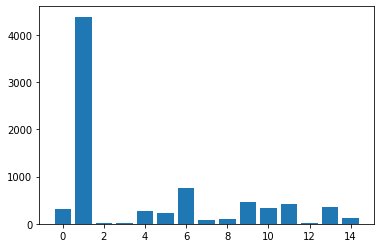

In [ ]:
#SMOTE is an example of over sampling in which we increase the minority samples of the target variable to the majority samples.
oversample = SMOTE()

# generate dataset
df_strokedata_X = df_strokedata.drop(columns = ['id','stroke'])
df_strokedata_y = df_strokedata['stroke']

x_train, x_test, y_train, y_test = train_test_split(df_strokedata_X, df_strokedata_y,test_size=0.2)#, random_state=42)

X_train_smote, y_train_smote = oversample.fit_resample(x_train,y_train)
X_test_smote, y_test_smote = oversample.fit_resample(x_test,y_test)



# ANOVA feature selection for numeric input and categorical output
# define feature selection
fs = SelectKBest(score_func=f_classif, k='all')
# apply feature selection
fs_scores = fs.fit_transform(X_train_smote, y_train_smote)
for i in range(len(fs.scores_)):
 print('Feature %d : %s: %f' % (i, X_train_smote.columns[i], fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()



In [ ]:
x_train_fs = X_train_smote[['age','ever_married','gender','Residence_type','avg_glucose_level','smoking_status_formerly smoked','smoking_status_never smoked','smoking_status_smokes']]
x_test_fs = X_test_smote[['age','ever_married','gender','Residence_type','avg_glucose_level','smoking_status_formerly smoked','smoking_status_never smoked','smoking_status_smokes']]

Cross Validation Score :  98.45%
ROC_AUC Score :  74.72%


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


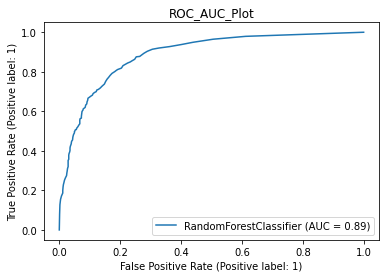

              precision    recall  f1-score   support

           0       0.68      0.93      0.79       965
           1       0.89      0.56      0.69       965

    accuracy                           0.75      1930
   macro avg       0.79      0.75      0.74      1930
weighted avg       0.79      0.75      0.74      1930



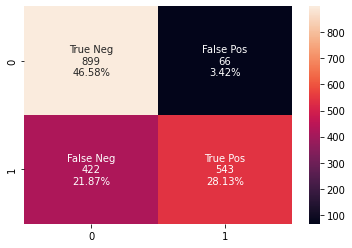

In [ ]:
# RandomForest
clf = RandomForestClassifier()
clf.fit(x_train_fs, y_train_smote)
y_pred = clf.predict(x_test_fs)

cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(clf,x_train_fs,y_train_smote,cv = cv,scoring = 'roc_auc').mean()))
print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test_smote,y_pred)))
plot_roc_curve(clf, x_test_fs,y_test_smote)
plt.title('ROC_AUC_Plot')
plt.show()

## Model Evaluation

# Confusion Matrix
cm = confusion_matrix(y_test_smote,clf.predict(x_test_fs))
names = ['True Neg','False Pos','False Neg','True Pos']
counts = [value for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm,annot = labels,fmt ='')

# Classification Report
print(classification_report(y_test_smote,clf.predict(x_test_fs)))

Cross Validation Score :  98.37%
ROC_AUC Score :  72.54%


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


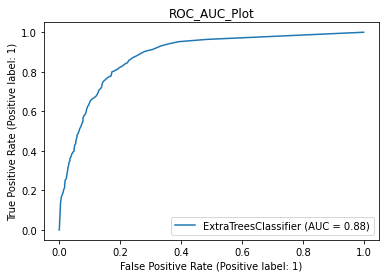

              precision    recall  f1-score   support

           0       0.66      0.93      0.77       965
           1       0.88      0.52      0.65       965

    accuracy                           0.73      1930
   macro avg       0.77      0.73      0.71      1930
weighted avg       0.77      0.73      0.71      1930



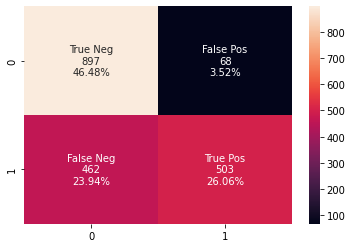

In [ ]:
# Trees

clf = ExtraTreesClassifier()
clf.fit(x_train_fs, y_train_smote)
y_pred = clf.predict(x_test_fs)

cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(clf,x_train_fs,y_train_smote,cv = cv,scoring = 'roc_auc').mean()))
print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test_smote,y_pred)))
plot_roc_curve(clf, x_test_fs,y_test_smote)
plt.title('ROC_AUC_Plot')
plt.show()

## Model Evaluation

# Confusion Matrix
cm = confusion_matrix(y_test_smote,clf.predict(x_test_fs))
names = ['True Neg','False Pos','False Neg','True Pos']
counts = [value for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm,annot = labels,fmt ='')

# Classification Report
print(classification_report(y_test_smote,clf.predict(x_test_fs)))

Cross Validation Score :  91.81%
ROC_AUC Score :  70.47%


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


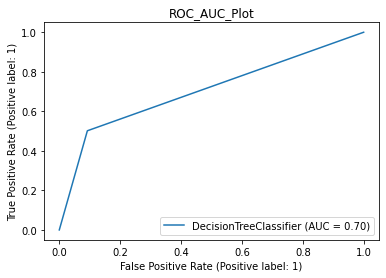

              precision    recall  f1-score   support

           0       0.65      0.91      0.75       965
           1       0.84      0.50      0.63       965

    accuracy                           0.70      1930
   macro avg       0.75      0.70      0.69      1930
weighted avg       0.75      0.70      0.69      1930



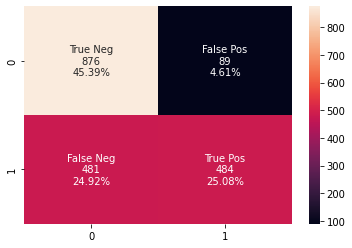

In [ ]:
# DecisionTree

clf = DecisionTreeClassifier()
clf.fit(x_train_fs, y_train_smote)
y_pred = clf.predict(x_test_fs)

cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(clf,x_train_fs,y_train_smote,cv = cv,scoring = 'roc_auc').mean()))
print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test_smote,y_pred)))
plot_roc_curve(clf, x_test_fs,y_test_smote)
plt.title('ROC_AUC_Plot')
plt.show()

## Model Evaluation

# Confusion Matrix
cm = confusion_matrix(y_test_smote,clf.predict(x_test_fs))
names = ['True Neg','False Pos','False Neg','True Pos']
counts = [value for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm,annot = labels,fmt ='')

# Classification Report
print(classification_report(y_test_smote,clf.predict(x_test_fs)))

Cross Validation Score :  85.92%
ROC_AUC Score :  74.46%


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


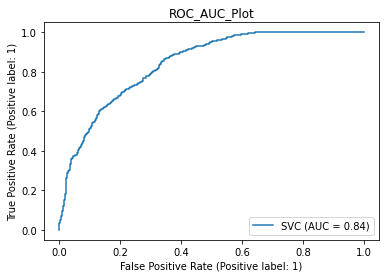

              precision    recall  f1-score   support

           0       0.76      0.72      0.74       965
           1       0.73      0.77      0.75       965

    accuracy                           0.74      1930
   macro avg       0.75      0.74      0.74      1930
weighted avg       0.75      0.74      0.74      1930



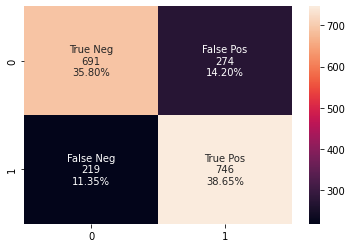

In [ ]:
# Support Vector
clf = SVC()
clf.fit(x_train_fs, y_train_smote)
y_pred = clf.predict(x_test_fs)

cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(clf,x_train_fs,y_train_smote,cv = cv,scoring = 'roc_auc').mean()))
print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test_smote,y_pred)))
plot_roc_curve(clf, x_test_fs,y_test_smote)
plt.title('ROC_AUC_Plot')
plt.show()

## Model Evaluation

# Confusion Matrix
cm = confusion_matrix(y_test_smote,clf.predict(x_test_fs))
names = ['True Neg','False Pos','False Neg','True Pos']
counts = [value for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm,annot = labels,fmt ='')

# Classification Report
print(classification_report(y_test_smote,clf.predict(x_test_fs)))

Cross Validation Score :  95.29%
ROC_AUC Score :  84.40%


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


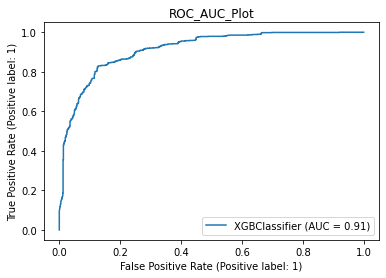

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       965
           1       0.85      0.83      0.84       965

    accuracy                           0.84      1930
   macro avg       0.84      0.84      0.84      1930
weighted avg       0.84      0.84      0.84      1930



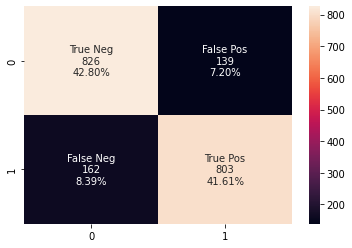

In [ ]:
# XG Boost

clf = XGBClassifier()
clf.fit(x_train_fs, y_train_smote)
y_pred = clf.predict(x_test_fs)

cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(clf,x_train_fs,y_train_smote,cv = cv,scoring = 'roc_auc').mean()))
print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test_smote,y_pred)))
plot_roc_curve(clf, x_test_fs,y_test_smote)
plt.title('ROC_AUC_Plot')
plt.show()

## Model Evaluation

# Confusion Matrix
cm = confusion_matrix(y_test_smote,clf.predict(x_test_fs))
names = ['True Neg','False Pos','False Neg','True Pos']
counts = [value for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm,annot = labels,fmt ='')

# Classification Report
print(classification_report(y_test_smote,clf.predict(x_test_fs)))

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Cross Validation Score :  92.42%
ROC_AUC Score :  83.78%


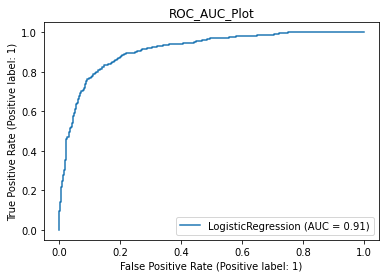

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       965
           1       0.83      0.84      0.84       965

    accuracy                           0.84      1930
   macro avg       0.84      0.84      0.84      1930
weighted avg       0.84      0.84      0.84      1930



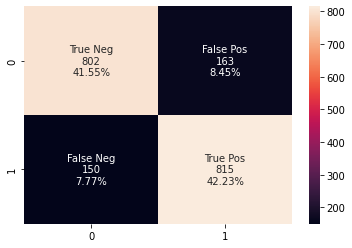

In [ ]:
# Logistics Regression

clf = LogisticRegression()
clf.fit(x_train_fs, y_train_smote)
y_pred = clf.predict(x_test_fs)

cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(clf,x_train_fs,y_train_smote,cv = cv,scoring = 'roc_auc').mean()))
print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test_smote,y_pred)))
plot_roc_curve(clf, x_test_fs,y_test_smote)
plt.title('ROC_AUC_Plot')
plt.show()

## Model Evaluation

# Confusion Matrix
cm = confusion_matrix(y_test_smote,clf.predict(x_test_fs))
names = ['True Neg','False Pos','False Neg','True Pos']
counts = [value for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm,annot = labels,fmt ='')

# Classification Report
print(classification_report(y_test_smote,clf.predict(x_test_fs)))

Cross Validation Score :  92.42%
ROC_AUC Score :  83.73%


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


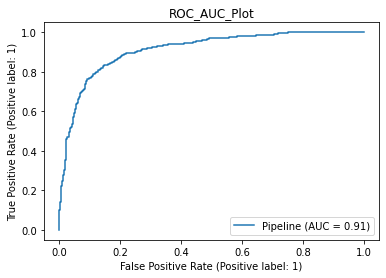

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       965
           1       0.83      0.84      0.84       965

    accuracy                           0.84      1930
   macro avg       0.84      0.84      0.84      1930
weighted avg       0.84      0.84      0.84      1930



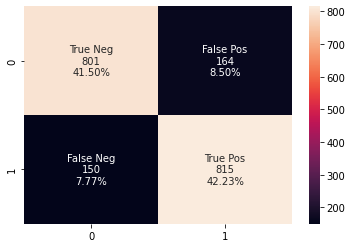

In [ ]:
# Logistics Regression

clf = LogisticRegression()
pipe = make_pipeline(StandardScaler(), clf)

pipe.fit(x_train_fs, y_train_smote)
y_pred = pipe.predict(x_test_fs)

cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(pipe,x_train_fs,y_train_smote,cv = cv,scoring = 'roc_auc').mean()))
print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test_smote,y_pred)))
plot_roc_curve(pipe, x_test_fs,y_test_smote)
plt.title('ROC_AUC_Plot')
plt.show()

## Model Evaluation

# Confusion Matrix
cm = confusion_matrix(y_test_smote,pipe.predict(x_test_fs))
names = ['True Neg','False Pos','False Neg','True Pos']
counts = [value for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm,annot = labels,fmt ='')

# Classification Report
print(classification_report(y_test_smote,pipe.predict(x_test_fs)))